In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x+5

f(4.2)

41.120000000000005

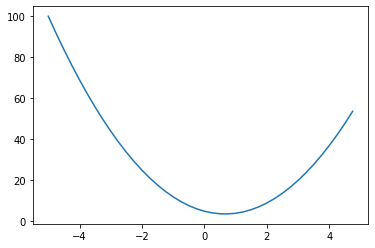

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
# derivative at 2/3

h = 0.001
x = 2/3
(f(x+h) - f(x))/h

0.0029999999995311555

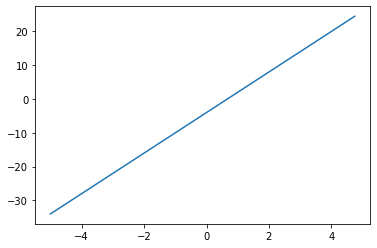

In [9]:
# derivative of f at all points

def d():
    ds = []
    h = 0.001
    for i in range(len(ys)):
        ds.append((f(xs[i]+h) - f(xs[i]))/h)
    return ds
ds=d()
plt.plot(xs, ds)

In [27]:
# More complex 

h = 0.001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print(f"d1 {d1}")
print(f"d2 {d2}")
print(f"slope", (d2 - d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [19]:
class Value:

    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return (f"Value(data) = {self.data}")

    def __add__(self, other):
        out = Value(self.data+ other.data, (self,other), _op="+")
        
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        
        return out
    # def __sub__(self,other):
    #     out = Value(self.data-other.data,(self,other),_op="-")
    #     return out
    # def __div__(self,other):
    #     out = Value(self.data/other.data,(self,other),_op="/")
    #     return out

    def __mul__(self, other):
        out = Value(self.data * other.data,(self, other), _op="*")
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out=Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        "https://bit.ly/sortTopological"
        # "topological sort" to let every neuron get its gradient 
        #set as a sum of all dependencies
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                    topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [118]:
a = Value(2.1, label="a")
b = Value(5, label="b")
c = Value(10, label="c")
d = a * b + c
d._prev

{Value(data)=10, Value(data)=10.5}

In [ ]:
# download link for graphwiz on windows: https://graphviz.org/download
import os
os.environ["PATH"] += os.pathsep + 'F:\\softwares\\Graphviz\\bin'

In [17]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [21]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data) = -8.0

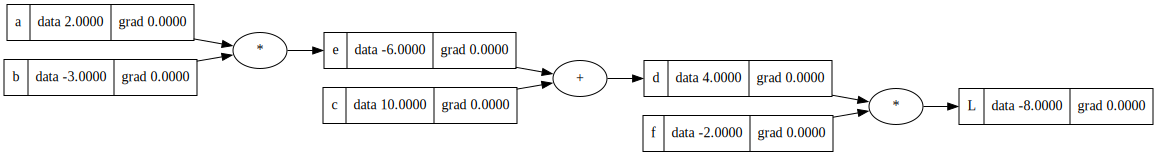

In [22]:
draw_dot(L)

In [24]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w1')

#bias of the neuron this specific number for numbers comming out nicely
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1+x2w2"

n = x1w1x2w2+b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'


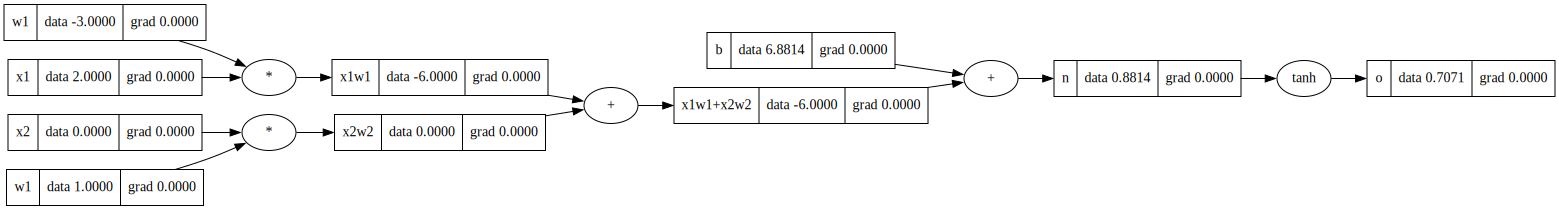

In [25]:
draw_dot(o)

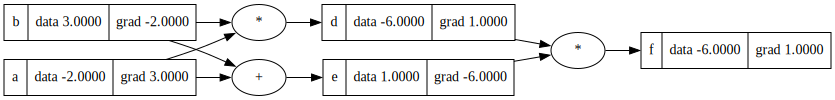

In [26]:

a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)